In [1]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [27]:
# https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects

In [2]:
import os
import random
import joblib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, f1_score
from imblearn.metrics import (
    classification_report_imbalanced,
    geometric_mean_score,
    make_index_balanced_accuracy
)

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from imblearn.ensemble import RUSBoostClassifier
from lightgbm import LGBMClassifier

set_config(display='diagram')
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [3]:
random.seed(0)
np.random.seed(0)
os.environ["PYTHONHASHSEED"] = str(0)

In [6]:
df = pd.read_csv("../Data/neo_v2.csv")
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


<AxesSubplot:xlabel='count', ylabel='hazardous'>

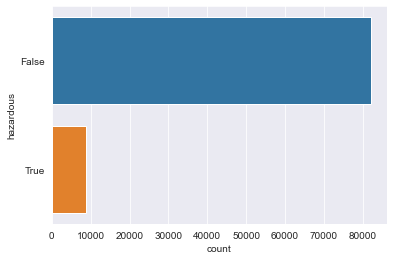

In [8]:
sns.countplot(y='hazardous', data=df)

In [9]:
df.columns

Index(['id', 'name', 'est_diameter_min', 'est_diameter_max',
       'relative_velocity', 'miss_distance', 'orbiting_body', 'sentry_object',
       'absolute_magnitude', 'hazardous'],
      dtype='object')

In [10]:
df['sentry_object'].value_counts()

False    90836
Name: sentry_object, dtype: int64

In [11]:
df['orbiting_body'].value_counts()

Earth    90836
Name: orbiting_body, dtype: int64

In [12]:
df.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99])

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
80%,5.401684e+07,0.182203,0.407418,67870.598602,6.028160e+07,26.100000
90%,5.414283e+07,0.305179,0.682402,82071.928548,6.749341e+07,27.200000
95%,5.421522e+07,0.470495,1.052059,95214.588889,7.117708e+07,28.000000


In [13]:
df.drop(columns=['id', 'name', 'sentry_object', 'orbiting_body'], inplace=True)

In [14]:
df

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True
...,...,...,...,...,...,...
90831,0.026580,0.059435,52078.886692,1.230039e+07,25.00,False
90832,0.016771,0.037501,46114.605073,5.432121e+07,26.00,False
90833,0.031956,0.071456,7566.807732,2.840077e+07,24.60,False
90834,0.007321,0.016370,69199.154484,6.869206e+07,27.80,False


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['hazardous']), df['hazardous'])
X_train.shape, X_test.shape

((68127, 5), (22709, 5))

In [16]:
pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression())
]).fit(X_train, y_train)

pipeline

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())])

                   pre       rec       spe        f1       geo       iba       sup

      False       0.91      0.99      0.07      0.94      0.26      0.07     20483
       True       0.33      0.07      0.99      0.11      0.26      0.06      2226

avg / total       0.85      0.90      0.16      0.86      0.26      0.07     22709



<AxesSubplot:>

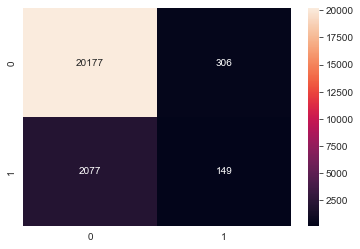

In [17]:
y_pred = pipeline.predict(X_test)

print(classification_report_imbalanced(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

In [18]:
scoring = {
    "f1_score": make_scorer(f1_score),
    "index_balanced_acc": make_scorer(make_index_balanced_accuracy()(geometric_mean_score))
}

In [20]:
param_grid = {
    "scaler": [
        MinMaxScaler(),
        RobustScaler(),
        QuantileTransformer()
    ],
    "model": [
        LogisticRegression(n_jobs=-1),
        LinearSVC(),
        ExtraTreesClassifier(n_jobs=-1),
        LGBMClassifier(n_jobs=-1),
        VotingClassifier(estimators=[
            ("logistic", LogisticRegression(n_jobs=-1)),
            ("svc", LinearSVC()),
            ("extra_tree", ExtraTreesClassifier(n_jobs=-1)),
            ("lgbm", LGBMClassifier(n_jobs=-1)),
        ], n_jobs=-1),
        RUSBoostClassifier(base_estimator=LogisticRegression(n_jobs=-1), random_state=0),
    ]
}

In [21]:
gscv = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit="index_balanced_acc",
    n_jobs=-1,
    verbose=2
).fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [22]:
cv_results = pd.DataFrame(gscv.cv_results_).sort_values('rank_test_index_balanced_acc')
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_scaler,params,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,...,std_test_f1_score,rank_test_f1_score,split0_test_index_balanced_acc,split1_test_index_balanced_acc,split2_test_index_balanced_acc,split3_test_index_balanced_acc,split4_test_index_balanced_acc,mean_test_index_balanced_acc,std_test_index_balanced_acc,rank_test_index_balanced_acc
17,3.039320,0.352587,0.096936,0.025365,RUSBoostClassifier(base_estimator=LogisticRegr...,QuantileTransformer(),{'model': RUSBoostClassifier(base_estimator=Lo...,0.441572,0.438446,0.447992,...,0.003111,4,0.716569,0.711646,0.722410,0.714875,0.712783,0.715657,0.003778,1
16,3.231188,0.189376,0.112493,0.011202,RUSBoostClassifier(base_estimator=LogisticRegr...,RobustScaler(),{'model': RUSBoostClassifier(base_estimator=Lo...,0.400184,0.405446,0.413021,...,0.006238,5,0.542411,0.572647,0.592943,0.576543,0.609330,0.578775,0.022357,2
15,2.870971,0.067451,0.110298,0.004618,RUSBoostClassifier(base_estimator=LogisticRegr...,MinMaxScaler(),{'model': RUSBoostClassifier(base_estimator=Lo...,0.341251,0.337382,0.337922,...,0.008726,6,0.543186,0.534378,0.531013,0.556297,0.511034,0.535181,0.014907,3
8,3.617334,0.310870,0.723827,0.430018,ExtraTreesClassifier(n_jobs=-1),QuantileTransformer(),"{'model': ExtraTreesClassifier(n_jobs=-1), 'sc...",0.499346,0.504946,0.476734,...,0.009970,1,0.419060,0.428722,0.396953,0.413800,0.406844,0.413076,0.010770,4
6,3.195684,0.493256,0.998283,0.478876,ExtraTreesClassifier(n_jobs=-1),MinMaxScaler(),"{'model': ExtraTreesClassifier(n_jobs=-1), 'sc...",0.485651,0.496703,0.464093,...,0.011039,2,0.402476,0.413626,0.378709,0.406148,0.408958,0.401983,0.012194,5
7,3.575645,0.334989,0.961379,0.382826,ExtraTreesClassifier(n_jobs=-1),RobustScaler(),"{'model': ExtraTreesClassifier(n_jobs=-1), 'sc...",0.484768,0.498906,0.465656,...,0.010599,3,0.401711,0.417112,0.382083,0.398716,0.401079,0.400140,0.011131,6
10,0.728610,0.047660,0.094542,0.006224,LGBMClassifier(),RobustScaler(),"{'model': LGBMClassifier(), 'scaler': RobustSc...",0.327125,0.305966,0.301549,...,0.012841,7,0.210428,0.194001,0.189775,0.181609,0.202037,0.195570,0.009935,7
9,0.694308,0.107260,0.088957,0.005141,LGBMClassifier(),MinMaxScaler(),"{'model': LGBMClassifier(), 'scaler': MinMaxSc...",0.307692,0.311191,0.306050,...,0.006093,8,0.194814,0.195117,0.193477,0.183650,0.187031,0.190818,0.004631,8
11,0.758331,0.056533,0.143011,0.070998,LGBMClassifier(),QuantileTransformer(),"{'model': LGBMClassifier(), 'scaler': Quantile...",0.307692,0.311191,0.306050,...,0.006093,8,0.194814,0.195117,0.193477,0.183650,0.187031,0.190818,0.004631,8
2,0.363997,0.009424,0.033910,0.003026,LogisticRegression(n_jobs=-1),QuantileTransformer(),"{'model': LogisticRegression(n_jobs=-1), 'scal...",0.119723,0.134507,0.146250,...,0.013796,10,0.070820,0.079818,0.087344,0.073796,0.059898,0.074335,0.009169,10


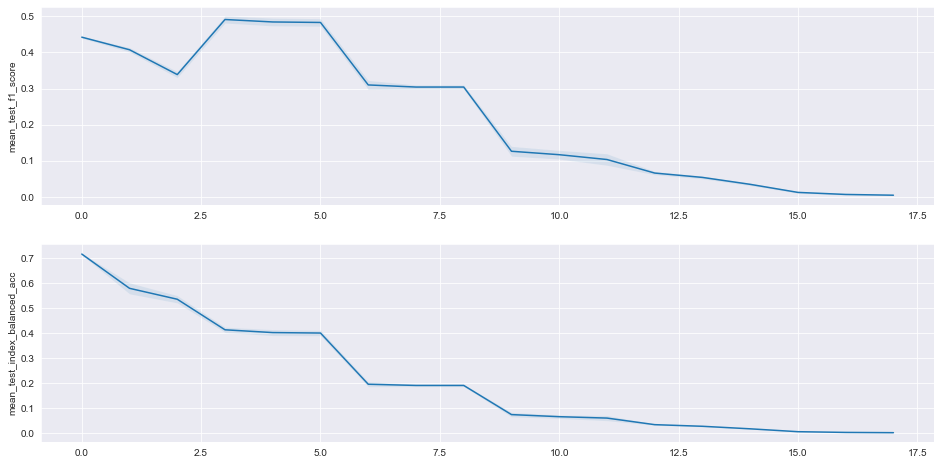

In [23]:
fig, axs = plt.subplots(nrows=2, figsize=(16,8))

test_sizes = np.arange(len(cv_results))
scoring_metrics = scoring.keys()

for metric, ax in zip(scoring_metrics, axs.ravel()):
    test_score_mean = cv_results['mean_test_' + metric]
    test_score_std = cv_results['std_test_' + metric]
    
    sns\
    .lineplot(x=test_sizes, y=test_score_mean, ax=ax)\
    .fill_between(
        test_sizes,
        test_score_mean - test_score_std,
        test_score_mean + test_score_std,
        alpha=0.1,
    )

In [24]:
best_estimator = gscv.best_estimator_
best_estimator

Pipeline(steps=[('scaler', QuantileTransformer()),
                ('model',
                 RUSBoostClassifier(base_estimator=LogisticRegression(n_jobs=-1),
                                    random_state=0))])

                   pre       rec       spe        f1       geo       iba       sup

      False       1.00      0.75      0.97      0.85      0.85      0.71     20483
       True       0.29      0.97      0.75      0.45      0.85      0.74      2226

avg / total       0.93      0.77      0.95      0.81      0.85      0.71     22709



<AxesSubplot:>

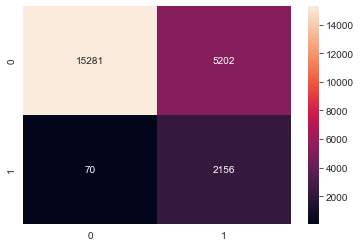

In [25]:
y_pred = best_estimator.predict(X_test)

print(classification_report_imbalanced(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

In [26]:
joblib.dump(best_estimator, "../Data/Near Earth Objects Hazardousness.pkl")

['../Data/Near Earth Objects Hazardousness.pkl']